In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs
from scipy.stats import ttest_ind

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32979 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:41497' processes=7 threads=14, memory=63.00 GiB>

In [3]:
def regrid_ACCESS(ds, var):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds[var].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [4]:
def regrid_ACCESS_u(ds, var):
    #rename coords
    ds = ds.rename({"geolon_c": "longitude", "geolat_c": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xu_ocean', 'yu_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds[var].chunk({'xu_ocean': -1, 'yu_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [5]:
def roll_lon(df):
    df.coords['longitude'] = (df.coords['longitude'] + 360) % 360# - 180
    df = df.sortby(df.longitude)
    return df

In [6]:
data_dir = "/g/data/e14/sm2435/Exps_ACCESS_initial/"

In [7]:
ctrl_z20 = xr.open_dataset(data_dir+"ctrl_z20.nc", use_cftime=True, chunks= {"time":240})

In [8]:
ctrl_z20 = regrid_ACCESS(ctrl_z20, 'z20')
ctrl_z20 = ctrl_z20.compute()

In [9]:
VC_z20 = xr.open_dataset(data_dir+"Var_pace_z20.nc", use_cftime=True, chunks= {"time":240})

In [10]:
OC_z20 = xr.open_dataset(data_dir+"obs_pace_z20.nc", use_cftime=True, chunks= {"time":240})

In [11]:
MC_z20 = xr.open_dataset(data_dir+"mod_pace_z20.nc", use_cftime=True, chunks= {"time":240})

In [12]:
OC_z20 = regrid_ACCESS(OC_z20, 'z20')
OC_z20 = OC_z20.compute()

In [13]:
VC_z20 = regrid_ACCESS(VC_z20, 'z20')
VC_z20 = VC_z20.compute()

In [14]:
MC_z20 = regrid_ACCESS(MC_z20, 'z20')
MC_z20 = MC_z20.compute()

In [15]:
ctrl_u = xr.open_dataset(data_dir+"ctrl_uwnd.nc", use_cftime=True, chunks= {"time":240})

In [16]:
ctrl_u = regrid_ACCESS_u(ctrl_u, 'tauu')
ctrl_u = ctrl_u.compute()

In [17]:
ctrl_v = xr.open_dataset(data_dir+"ctrl_vwnd.nc", use_cftime=True, chunks= {"time":240})

In [18]:
ctrl_v = regrid_ACCESS_u(ctrl_v, 'tauv')
ctrl_v = ctrl_v.compute()

In [19]:
VC_u = xr.open_dataset(data_dir+"var_uwnd.nc", use_cftime=True, chunks= {"time":240})
VC_u = regrid_ACCESS_u(VC_u, 'tauu')
VC_u = VC_u.compute()

In [20]:
VC_v = xr.open_dataset(data_dir+"var_vwnd.nc", use_cftime=True, chunks= {"time":240})
VC_v = regrid_ACCESS_u(VC_v, 'tauv')
VC_v = VC_v.compute()

In [21]:
OC_u = xr.open_dataset(data_dir+"ob_uwnd.nc", use_cftime=True, chunks= {"time":240})
OC_u = regrid_ACCESS_u(OC_u, 'tauu')
OC_u = OC_u.compute()

In [22]:
OC_v = xr.open_dataset(data_dir+"ob_vwnd.nc", use_cftime=True, chunks= {"time":240})
OC_v = regrid_ACCESS_u(OC_v, 'tauv')
OC_v = OC_v.compute()

In [23]:
MC_v = xr.open_dataset(data_dir+"mod_vwnd.nc", use_cftime=True, chunks= {"time":240})
MC_v = regrid_ACCESS_u(MC_v, 'tauv')
MC_v = MC_v.compute()

In [24]:
MC_u = xr.open_dataset(data_dir+"mod_uwnd.nc", use_cftime=True, chunks= {"time":240})
MC_u = regrid_ACCESS_u(MC_u, 'tauu')
MC_u = MC_u.compute()

In [25]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
VC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VAR_PACE_sst.nc",  use_cftime=True, chunks= {"time":240})
MC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_sst.nc",  use_cftime=True, chunks= {"time":240})
OC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_sst.nc",  use_cftime=True, chunks= {"time":240})

In [26]:
VC = regrid_ACCESS(VC, 'sst')
VC = VC.compute()

In [27]:
MC = regrid_ACCESS(MC, 'sst')
MC = MC.compute()

In [28]:
OC = regrid_ACCESS(OC, 'sst')
OC = OC.compute()

In [29]:
ctrl = regrid_ACCESS(ctrl_sst, 'sst')
ctrl = ctrl.compute()

In [30]:
MC_u = MC_u.sel(time = slice("0951-01-01", "1103-12-31"))
MC_v = MC_v.sel(time = slice("0951-01-01", "1103-12-31"))
MC_z20 = MC_z20.sel(time = slice("0951-01-01", "1103-12-31"))

In [31]:
ctrl_u = ctrl_u.sel(time = slice("0950-01-01", "1150-12-31"))
ctrl_v = ctrl_v.sel(time = slice("0950-01-01", "1150-12-31"))
ctrl_z20 = ctrl_z20.sel(time = slice("0950-01-01", "1150-12-31"))

In [32]:
def regrid_ACCESS_atmos(ds, var):
    #rename coords
    ds = ds.rename({"lon": "longitude", "lat": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    #ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds[var])#.chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [33]:
VC_pr = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_pr/VC_pr*.nc",
                          use_cftime=True, chunks= {"time":240})
OC_pr = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_pr/OC_pr*.nc",
                          use_cftime=True, chunks= {"time":240})
MC_pr = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_pr/MC_pr*.nc",
                          use_cftime=True, chunks= {"time":240})
ctrl_pr = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_pr/ctrl_pr*.nc",
                          use_cftime=True, chunks= {"time":240})


In [34]:
ctrl_pr = regrid_ACCESS_atmos(ctrl_pr, 'fld_s05i216')
ctrl_pr = ctrl_pr.compute()

In [35]:
OC_pr = regrid_ACCESS_atmos(OC_pr, 'fld_s05i216')
OC_pr = OC_pr.compute()

In [36]:
MC_pr = regrid_ACCESS_atmos(MC_pr, 'fld_s05i216')
MC_pr = MC_pr.compute()

In [37]:
VC_pr = regrid_ACCESS_atmos(VC_pr, 'fld_s05i216')
VC_pr = VC_pr.compute()

In [38]:
VC_psl = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_psl/VC_pr*.nc",
                          use_cftime=True, chunks= {"time":240})
OC_psl = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_psl/OC_pr*.nc",
                          use_cftime=True, chunks= {"time":240})
MC_psl = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_psl/MC_pr*.nc",
                          use_cftime=True, chunks= {"time":240})
ctrl_psl = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_psl/ctrl_pr*.nc",
                          use_cftime=True, chunks= {"time":240})


In [39]:
ctrl_psl = regrid_ACCESS_atmos(ctrl_psl, 'fld_s00i409')
ctrl_psl = ctrl_psl.compute()

In [40]:
OC_psl = regrid_ACCESS_atmos(OC_psl, 'fld_s00i409')
OC_psl = OC_psl.compute()

In [41]:
MC_psl = regrid_ACCESS_atmos(MC_psl, 'fld_s00i409')
MC_psl = MC_psl.compute()

In [42]:
VC_psl = regrid_ACCESS_atmos(VC_psl, 'fld_s00i409')
VC_psl = VC_psl.compute()

In [43]:
#roll_lon of all varibales so that it is easier to read them

In [44]:
#SST
ctrl = roll_lon(ctrl)
OC = roll_lon(OC)
MC = roll_lon(MC)
VC = roll_lon(VC)

In [45]:
#z20
ctrl_z20 = roll_lon(ctrl_z20)
OC_z20 = roll_lon(OC_z20)
MC_z20 = roll_lon(MC_z20)
VC_z20 = roll_lon(VC_z20)

In [46]:
#pr
ctrl_pr = roll_lon(ctrl_pr)
OC_pr = roll_lon(OC_pr)
MC_pr = roll_lon(MC_pr)
VC_pr = roll_lon(VC_pr)

In [47]:
#psl
ctrl_psl = roll_lon(ctrl_psl)
OC_psl = roll_lon(OC_psl)
MC_psl = roll_lon(MC_psl)
VC_psl = roll_lon(VC_psl)

In [48]:
#u
ctrl_u = roll_lon(ctrl_u)
OC_u = roll_lon(OC_u)
MC_u = roll_lon(MC_u)
VC_u = roll_lon(VC_u)

In [49]:
#v
ctrl_v = roll_lon(ctrl_v)
OC_v = roll_lon(OC_v)
MC_v = roll_lon(MC_v)
VC_v = roll_lon(VC_v)

In [56]:
def plot_bias_sig_annual(ctrl, exp, temp_scale=2):
    ctrl_mn = ctrl.mean('time')
    exp_mn = exp.mean("time")
    # Now calculate significance for annual component
    dims = ('latitude', 'longitude')
    t_stat, p_value = ttest_ind(exp, ctrl)
    t_stat_ds = xr.DataArray(t_stat, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
    p_value_ds = xr.DataArray(p_value, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
    sig_p = p_value_ds.where(p_value_ds < 0.05, np.nan)
    
    # Now plot figure
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    bias = (exp_mn - ctrl_mn)
    bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="RdBu_r", levels=10, extend='both',
                       transform=ccrs.PlateCarree())

    ax.coastlines(color='k')
    ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
    ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
    ax.gridlines()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
   
    # Plot significance
    ax.contourf(sig_p.longitude, sig_p.latitude, sig_p, levels=[0, 0.05],
                hatches=['///'], alpha=0.0, add_colorbar=False, transform=ccrs.PlateCarree())
    
    return



/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'ENSO no Bias - CTRL SST')

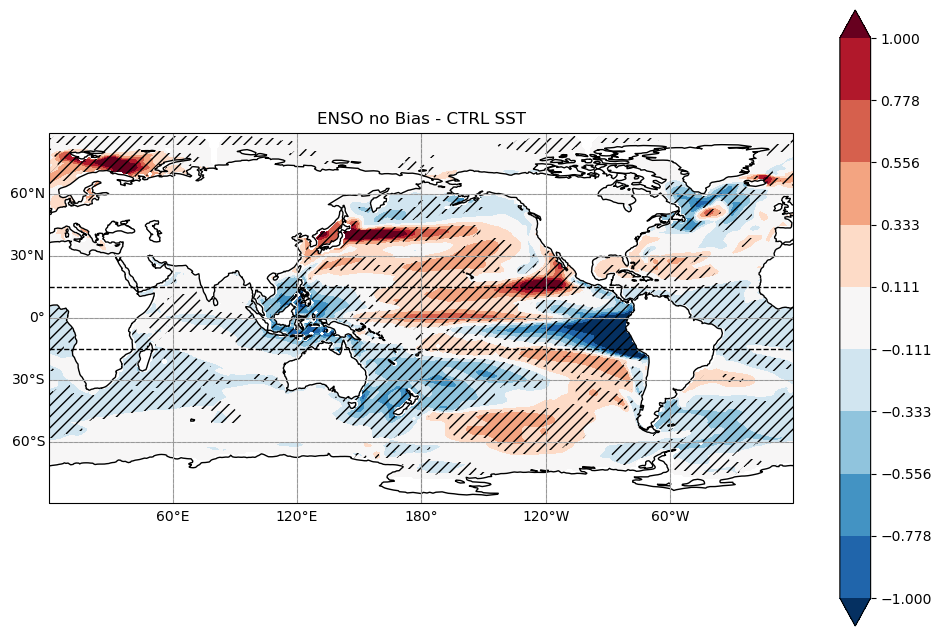

In [85]:
plot_bias_sig_annual(ctrl, VC, temp_scale=1)
plt.title("ENSO no Bias - CTRL SST")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'No ENSO no Bias - CTRL SST')

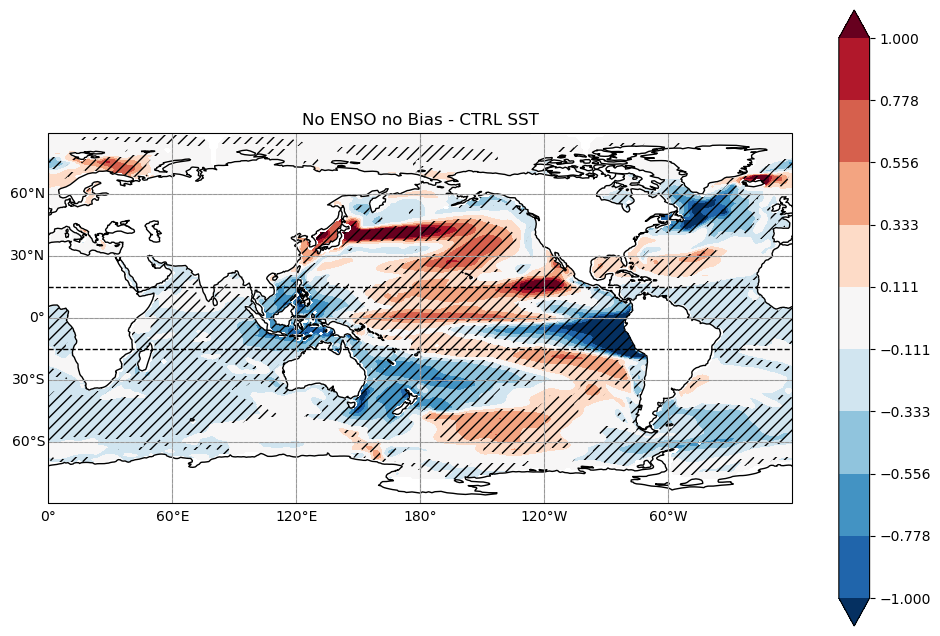

In [44]:
plot_bias_sig_annual(ctrl, OC, temp_scale=1)
plt.title("No ENSO no Bias - CTRL SST")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'No ENSO - CTRL SST')

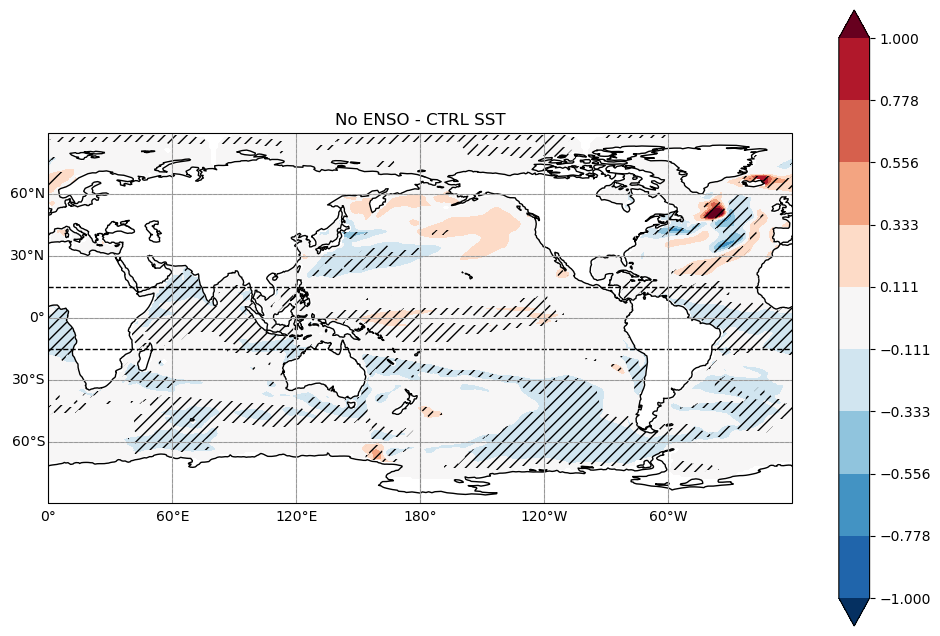

In [45]:
plot_bias_sig_annual(ctrl, MC, temp_scale=1)
plt.title("No ENSO - CTRL SST")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'ENSO no Bias - CTRL z20')

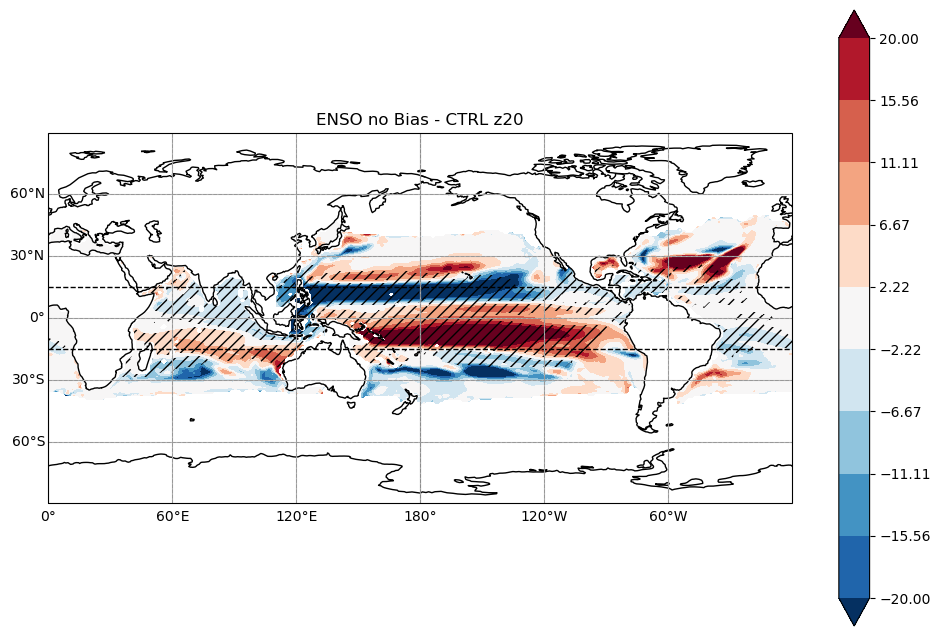

In [46]:
plot_bias_sig_annual(ctrl_z20, VC_z20, temp_scale=20)
plt.title("ENSO no Bias - CTRL z20")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'No ENSO no Bias - CTRL z20')

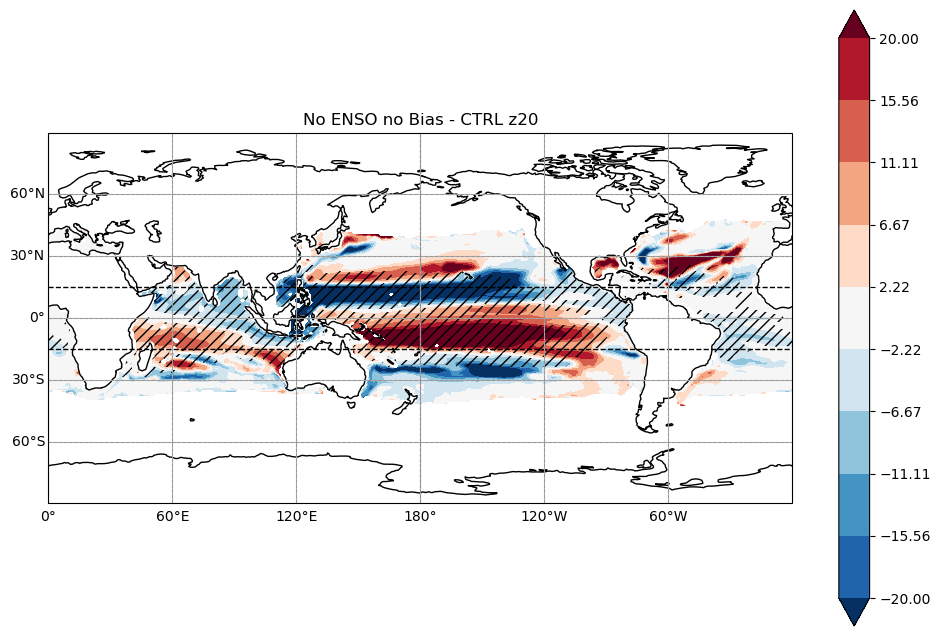

In [47]:
plot_bias_sig_annual(ctrl_z20, OC_z20, temp_scale=20)
plt.title("No ENSO no Bias - CTRL z20")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'No ENSO - CTRL z20')

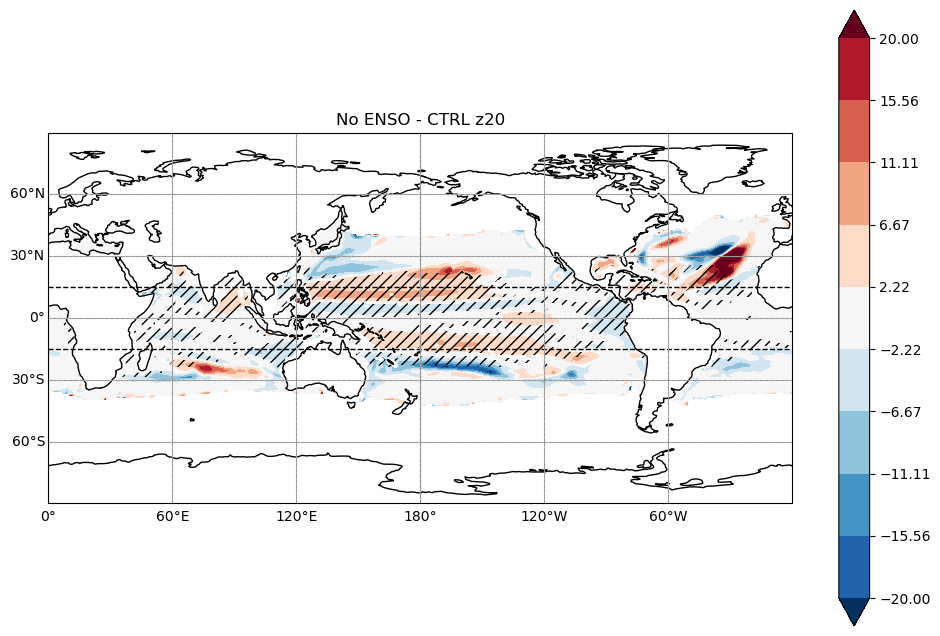

In [48]:
plot_bias_sig_annual(ctrl_z20, MC_z20, temp_scale=20)
plt.title("No ENSO - CTRL z20")

In [55]:
#now write a fucntion to output bias and to optioanlly plot
def plot_bias_sig(exp_u, exp_v, ref_u, ref_v, temp_scale = 2):
    # Ref dataset
    ref_str = np.sqrt(ref_u**2+ref_v**2)
    ref_u = ref_u.mean('time')
    ref_v = ref_v.mean('time')
    ref_spd = ref_str.mean('time')
    # Exp dataset
    exp_str = np.sqrt(exp_u**2+exp_v**2)
    exp_u = exp_u.mean('time')
    exp_v = exp_v.mean('time')
    exp_spd = exp_str.mean('time')  
    #Now get bias
    u_bias = exp_u - ref_u
    v_bias = exp_v - ref_v
    spd_bias = exp_spd - ref_spd
    # Now plot figure
    plt.figure(figsize = (12,8))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    spd_bias.plot.contourf(ax=ax, vmin = -1*temp_scale, vmax = temp_scale, cmap = "RdBu_r", levels = 10, extend = 'both',
           transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='wind stress bias'))

    Q = ax.quiver(u_bias.longitude[::10].values, u_bias.latitude[::5].values,
                  u_bias[::5,::10].values, v_bias[::5,::10].values, 
              transform=ccrs.PlateCarree(), scale = 1, scale_units = 'width', width = 0.0015, headlength=3)

    #ax.set_title('Annual mean SST bias')
    ax.coastlines(color = 'k')
    ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
    ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
    ax.gridlines()
    #ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    qk = ax.quiverkey(Q, 0.9, 1.1, 0.05, r'$0.05 \frac{N}{m^2}$', labelpos='E',
               coordinates='axes')
    return 


Text(0.5, 1.0, 'ENSO no bias - CTRL sfc wind stress')

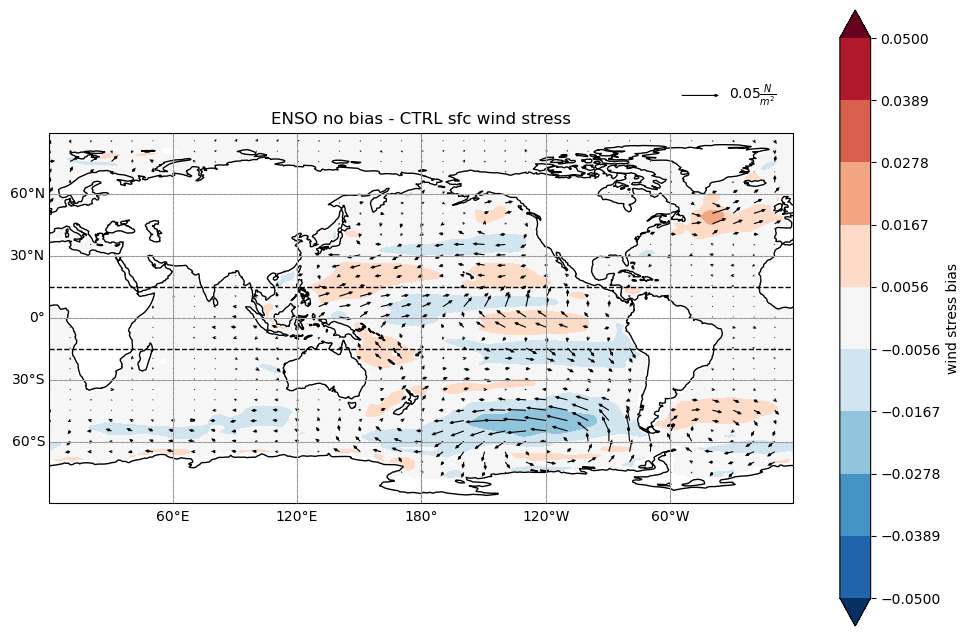

In [51]:
plot_bias_sig(VC_u, VC_v, ctrl_u, ctrl_v, temp_scale = 0.05)
plt.title("ENSO no bias - CTRL sfc wind stress")

Text(0.5, 1.0, 'No ENSO no bias - CTRL sfc wind stress')

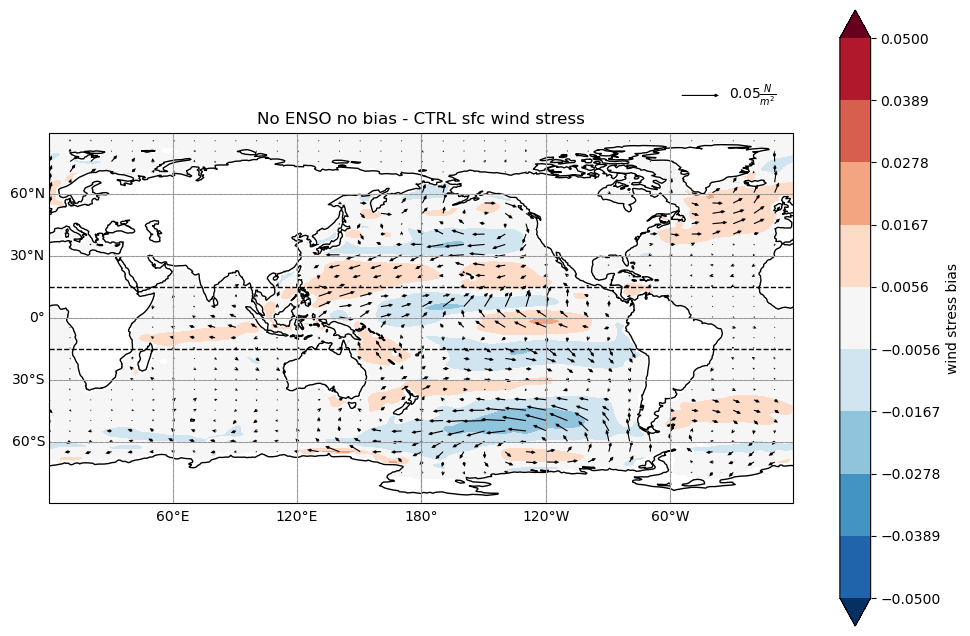

In [52]:
plot_bias_sig(OC_u, OC_v, ctrl_u, ctrl_v, temp_scale = 0.05)
plt.title("No ENSO no bias - CTRL sfc wind stress")

Text(0.5, 1.0, 'No ENSO - CTRL sfc wind stress')

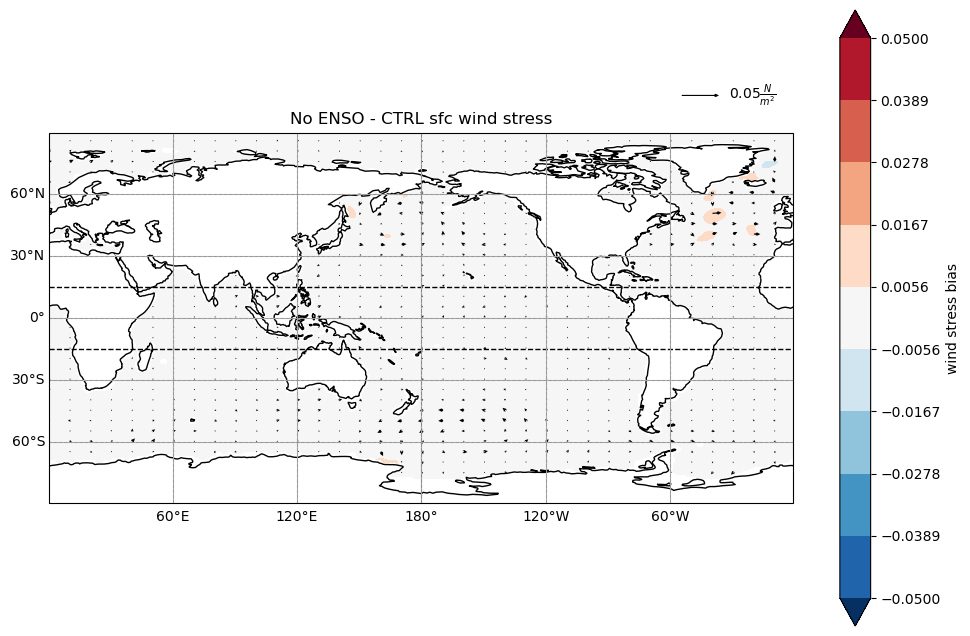

In [53]:
plot_bias_sig(MC_u, MC_v, ctrl_u, ctrl_v, temp_scale = 0.05)
plt.title("No ENSO - CTRL sfc wind stress")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'PSL ENSO no Bias - CTRL')

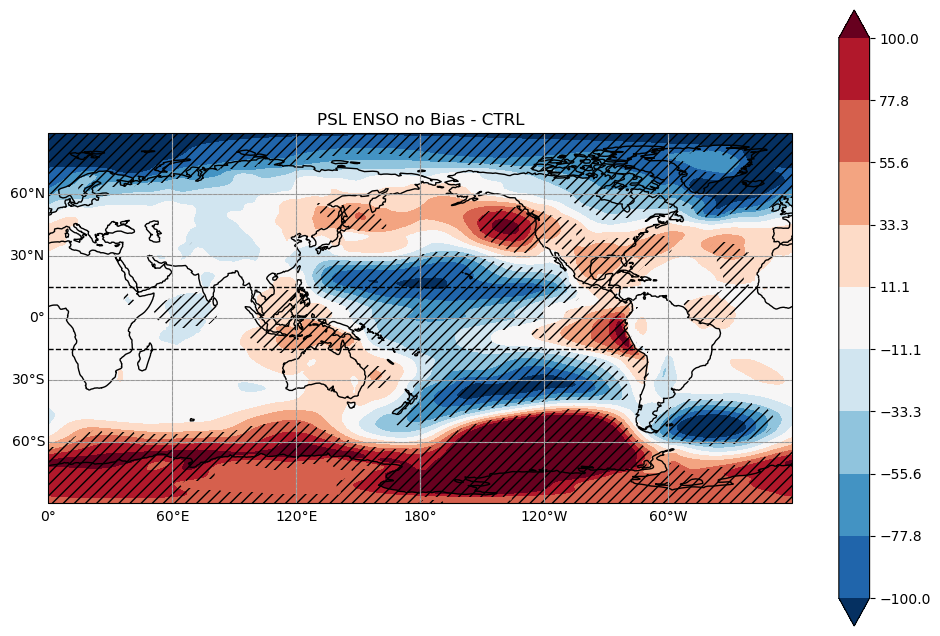

In [53]:
plot_bias_sig_annual(ctrl_psl, VC_psl, temp_scale=100)
plt.title("PSL ENSO no Bias - CTRL")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'PSL No ENSO no Bias - CTRL')

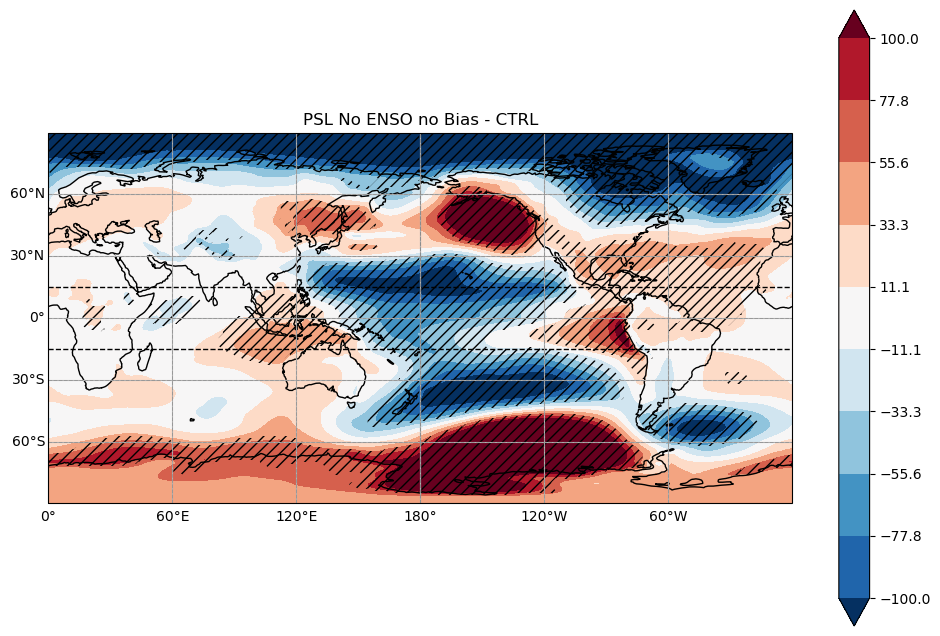

In [54]:
plot_bias_sig_annual(ctrl_psl, OC_psl, temp_scale=100)
plt.title("PSL No ENSO no Bias - CTRL")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'PSL No ENSO - CTRL')

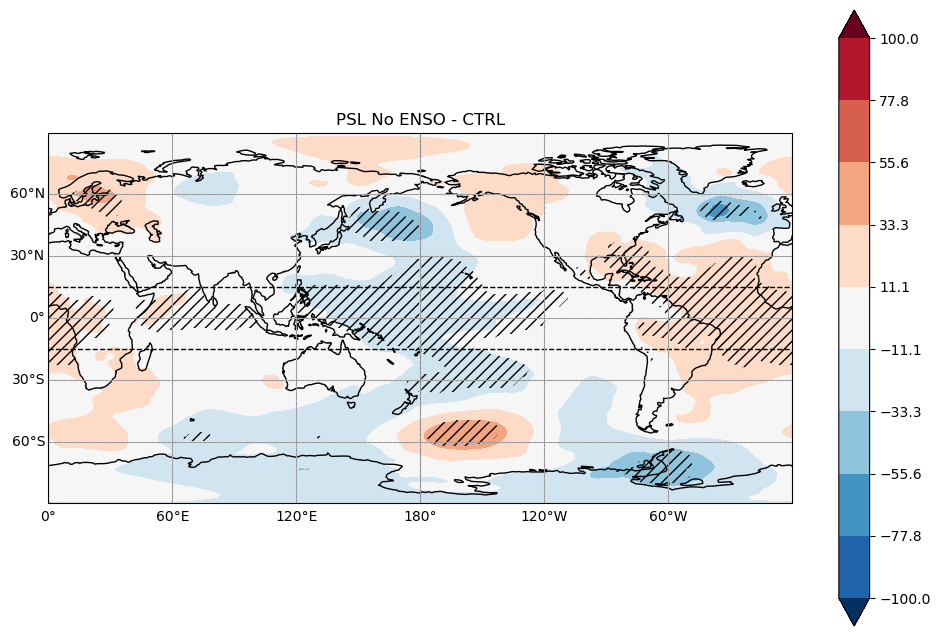

In [55]:
plot_bias_sig_annual(ctrl_psl, MC_psl, temp_scale=100)
plt.title("PSL No ENSO - CTRL")

In [54]:
def plot_bias_sig_annual_pr(ctrl, exp, temp_scale=2):
    ctrl_mn = 30*86400*ctrl.mean('time')
    exp_mn = 30*86400*exp.mean("time")
    # Now calculate significance for annual component
    dims = ('latitude', 'longitude')
    t_stat, p_value = ttest_ind(exp, ctrl)
    t_stat_ds = xr.DataArray(t_stat, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
    p_value_ds = xr.DataArray(p_value, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
    sig_p = p_value_ds.where(p_value_ds < 0.05, np.nan)
    
    # Now plot figure
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    bias = (exp_mn - ctrl_mn)
    bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="BrBG", levels=10, extend='both',
                       transform=ccrs.PlateCarree())

    ax.coastlines(color='k')
    ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
    ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
    ax.gridlines()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
   
    # Plot significance
    ax.contourf(sig_p.longitude, sig_p.latitude, sig_p, levels=[0, 0.05],
                hatches=['///'], alpha=0.0, add_colorbar=False, transform=ccrs.PlateCarree())
    
    return



/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'Precip No ENSO no Bias - CTRL')

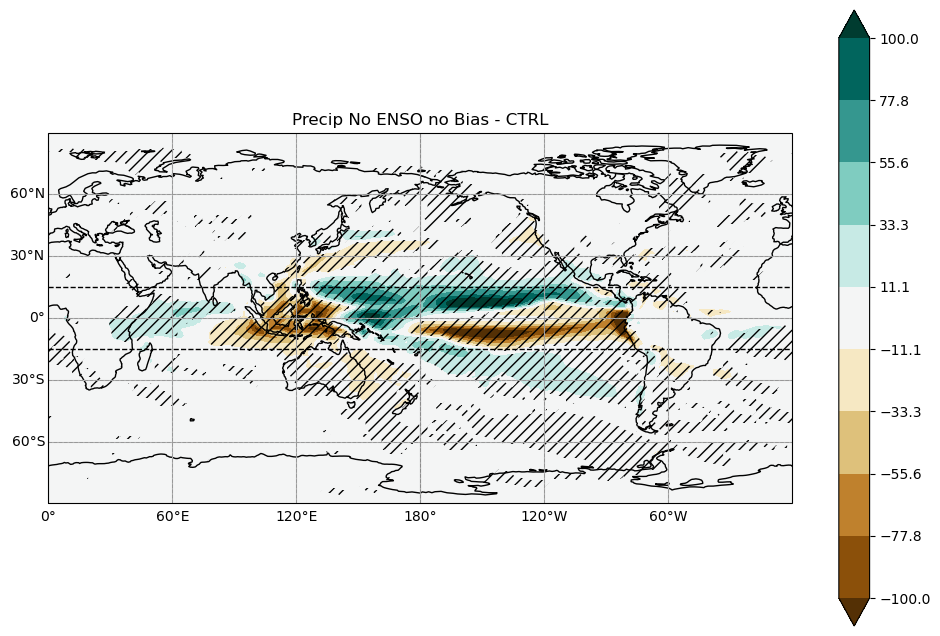

In [57]:
plot_bias_sig_annual_pr(ctrl_pr, OC_pr, temp_scale=100)
plt.title("Precip No ENSO no Bias - CTRL")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'Precip No ENSO - CTRL')

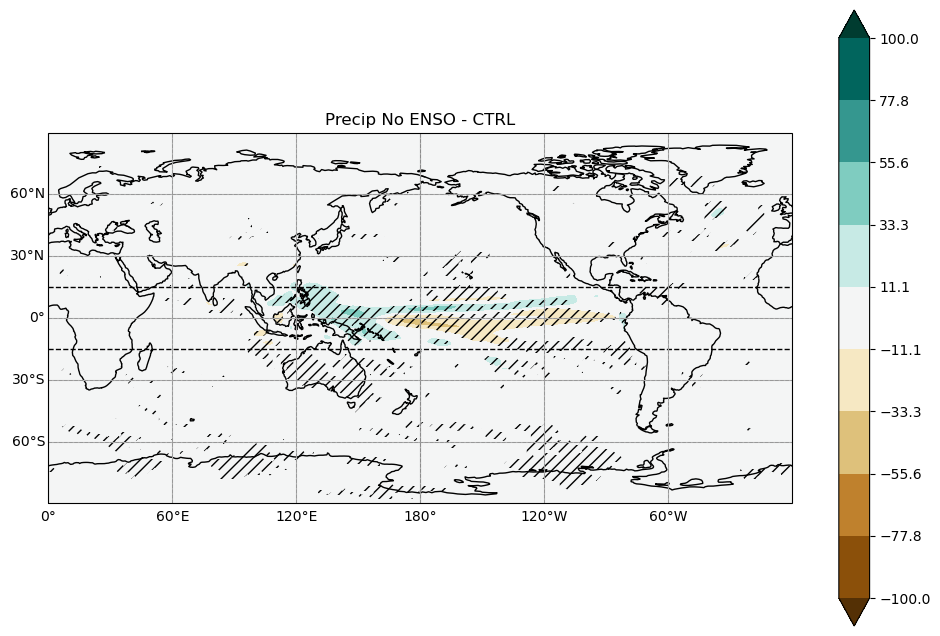

In [59]:
plot_bias_sig_annual_pr(ctrl_pr, MC_pr, temp_scale=100)
plt.title("Precip No ENSO - CTRL")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'Precip ENSO no Bias - CTRL')

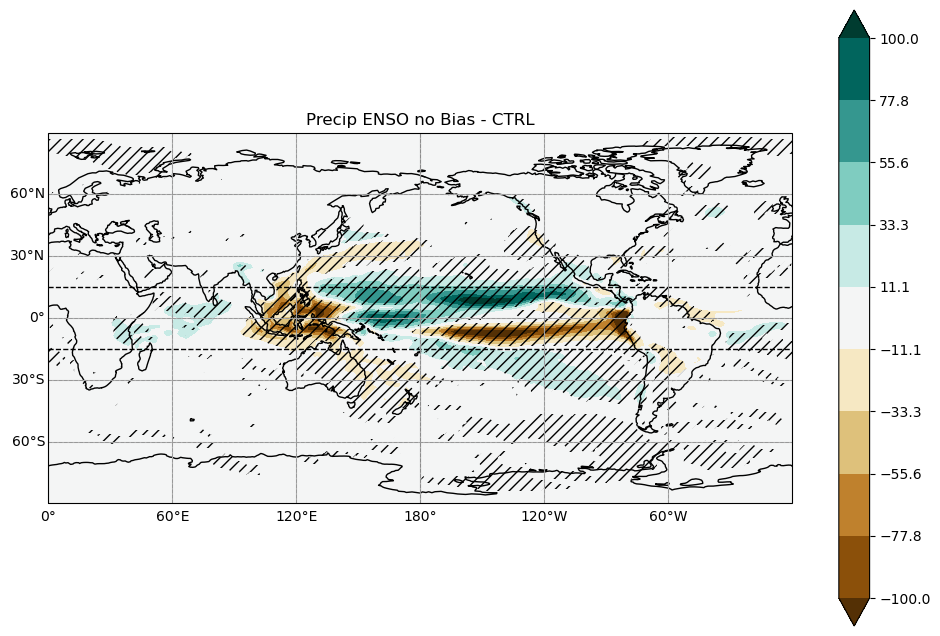

In [60]:
plot_bias_sig_annual_pr(ctrl_pr, VC_pr, temp_scale=100)
plt.title("Precip ENSO no Bias - CTRL")

Text(0.5, 1.0, 'Latitude of max precipitation (180W-90W)')

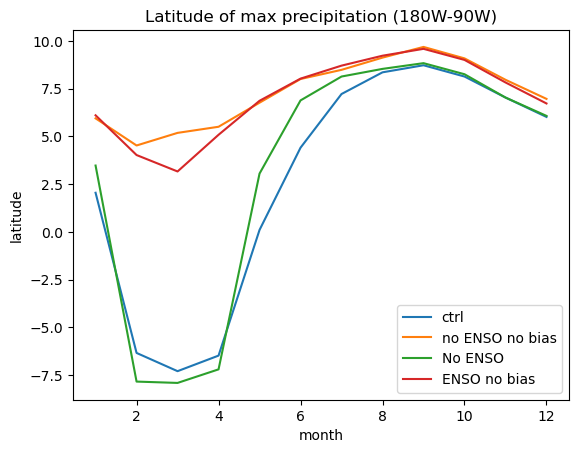

In [62]:
ctrl_pr.sel(longitude = slice(-180, -90)).mean(
    "longitude").idxmax("latitude").groupby("time.month").mean("time").plot(label = "ctrl")
OC_pr.sel(longitude = slice(-180, -90)).mean(
    "longitude").idxmax("latitude").groupby("time.month").mean("time").plot(label = "no ENSO no bias")
MC_pr.sel(longitude = slice(-180, -90)).mean(
    "longitude").idxmax("latitude").groupby("time.month").mean("time").plot(label = "No ENSO")
VC_pr.sel(longitude = slice(-180, -90)).mean(
    "longitude").idxmax("latitude").groupby("time.month").mean("time").plot(label = "ENSO no bias")
plt.legend()
plt.title("Latitude of max precipitation (180W-90W)")

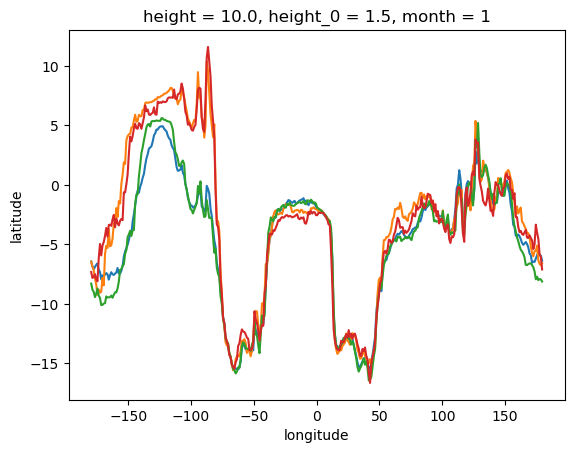

In [69]:
plt.figure()
ctrl_pr.sel(latitude = slice(-20, 25)).idxmax("latitude").groupby("time.month").mean("time")[0].plot()
OC_pr.sel(latitude = slice(-20, 25)).idxmax("latitude").groupby("time.month").mean("time")[0].plot()
MC_pr.sel(latitude = slice(-20, 25)).idxmax("latitude").groupby("time.month").mean("time")[0].plot()
VC_pr.sel(latitude = slice(-20, 25)).idxmax("latitude").groupby("time.month").mean("time")[0].plot()

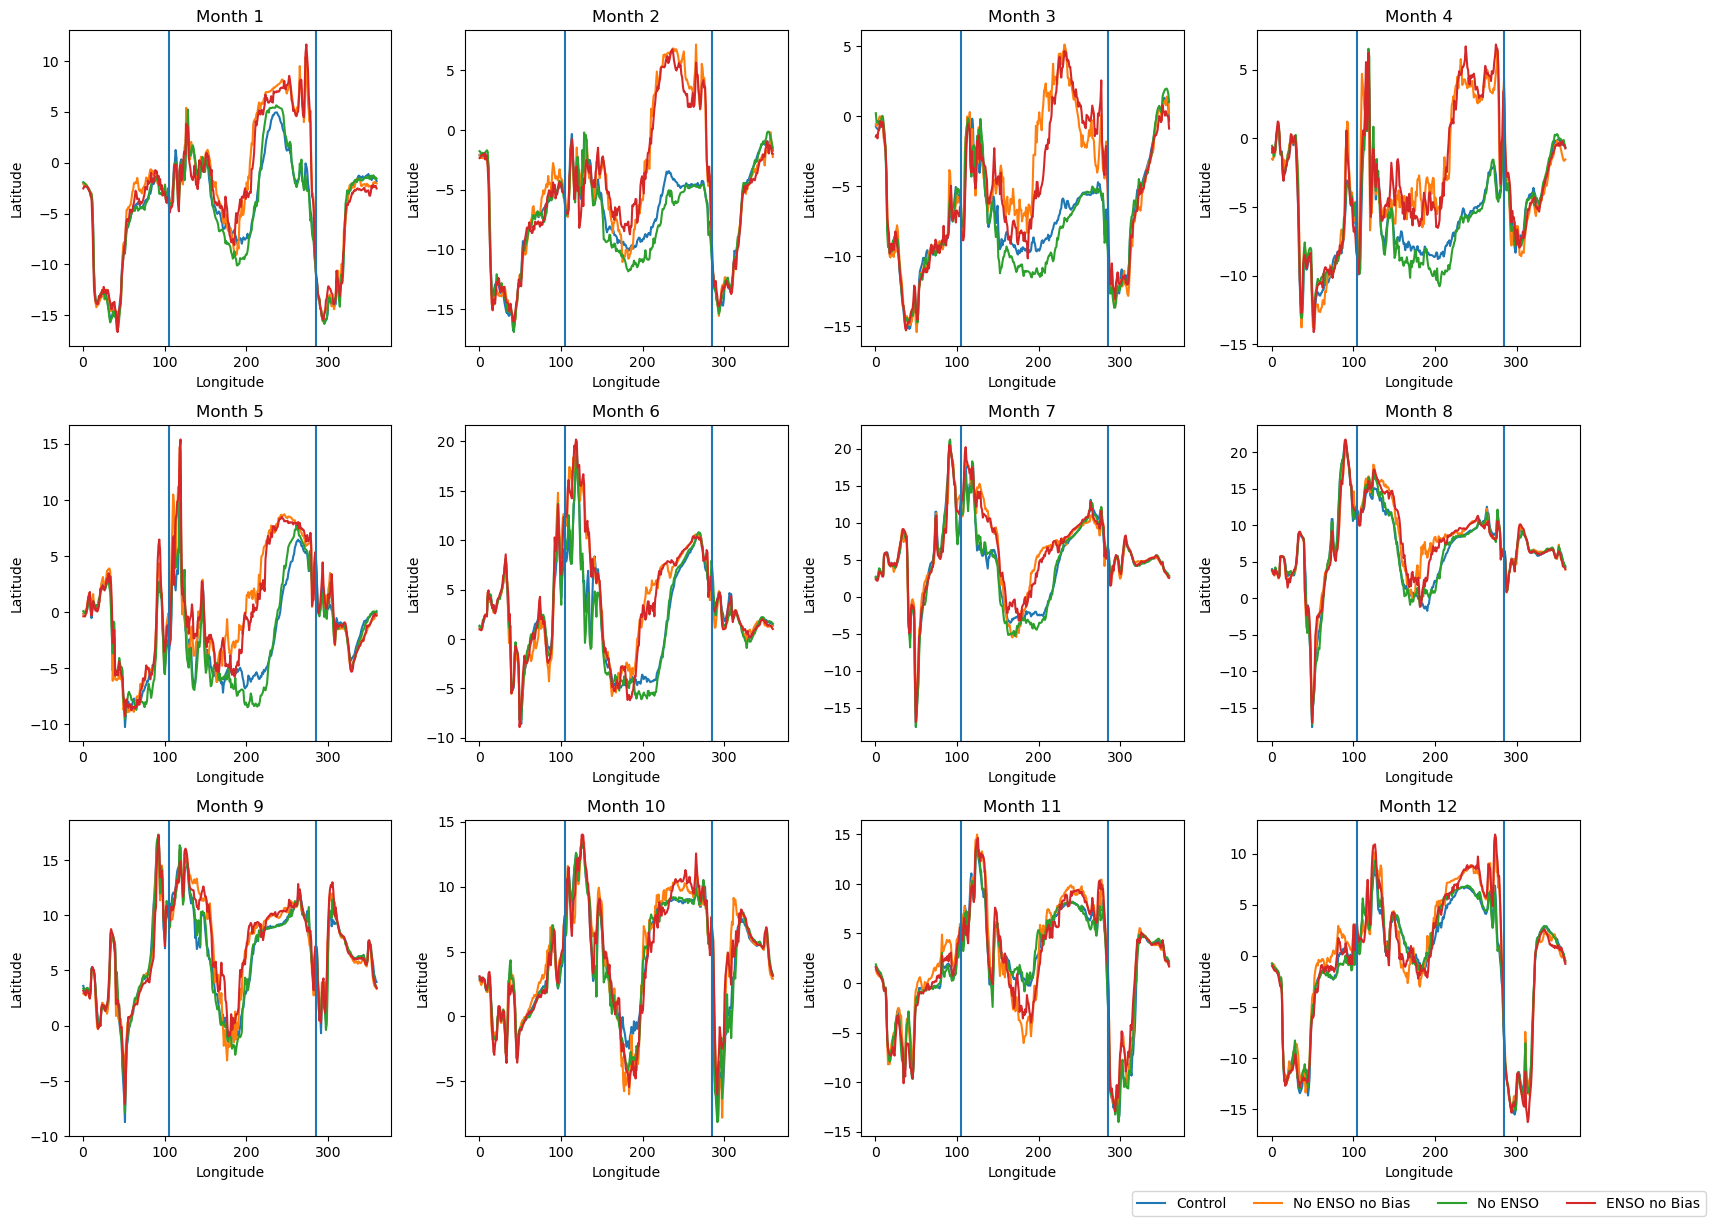

In [54]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
# Create an empty list to store legend handles and labels
legend_handles = []
# Iterate through values 0 to 11
for i in range(12):
    row = i // 4  # Calculate the row index
    col = i % 4   # Calculate the column index
    
    # Plot each dataset on the corresponding subplot
    ctrl_line, = ctrl_pr.sel(latitude=slice(-20, 25)).idxmax("latitude").groupby("time.month").mean("time")[i].plot(ax=axs[row, col], label="Control")
    oc_line, = OC_pr.sel(latitude=slice(-20, 25)).idxmax("latitude").groupby("time.month").mean("time")[i].plot(ax=axs[row, col], label="No ENSO no Bias")
    mc_line, = MC_pr.sel(latitude=slice(-20, 25)).idxmax("latitude").groupby("time.month").mean("time")[i].plot(ax=axs[row, col], label="No ENSO")
    vc_line, = VC_pr.sel(latitude=slice(-20, 25)).idxmax("latitude").groupby("time.month").mean("time")[i].plot(ax=axs[row, col], label="ENSO no Bias")
    axs[row, col].axvline(105)
    axs[row, col].axvline(360-75)
    axs[row, col].set_title(f"Month {i + 1}")
    axs[row, col].set_xlabel("Longitude")
    axs[row, col].set_ylabel("Latitude")
   # axs[row, col].legend()
    # Store the legend handles for later use
    legend_handles.extend([ctrl_line, oc_line, mc_line, vc_line])
# Adjust spacing between subplots
plt.tight_layout()
plt.legend(handles=legend_handles, labels=["Control", "No ENSO no Bias", "No ENSO", "ENSO no Bias"], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

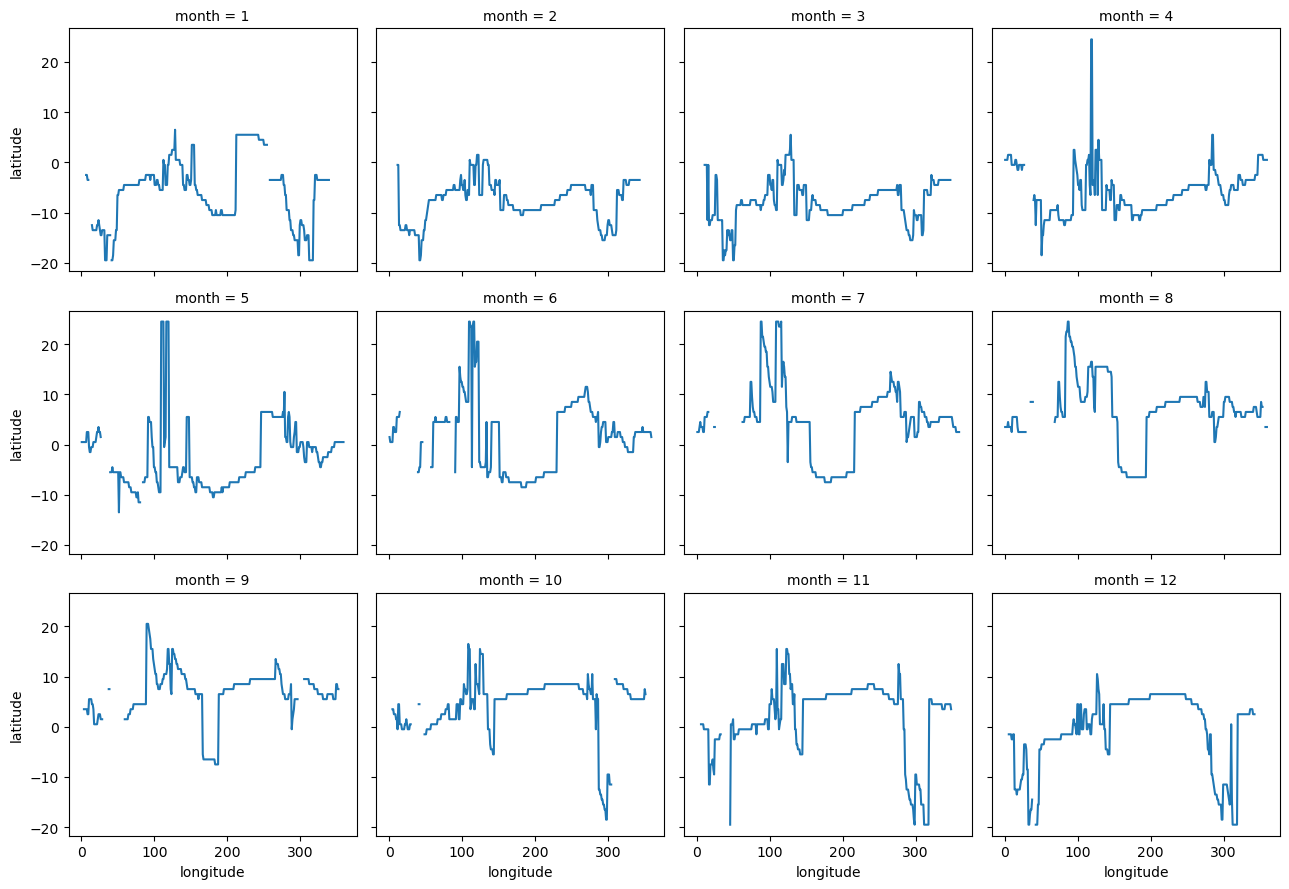

In [99]:
test = (30*86400*ctrl_pr).groupby("time.month").mean("time").where((30*86400*ctrl_pr).groupby("time.month").mean("time")>200)

test.sel(latitude=slice(-20, 25)).idxmax("latitude").plot(col = "month", col_wrap = 4, label="Control")

In [100]:
#lets load in VC files and see hwo to extract the U200 and u850 vatiables 

In [114]:
atm_vc = xr.open_mfdataset("/scratch/e14/sm2435/PACE_OC/cy286/history/atm/netCDF/cy286a.pm0960*_mon.nc", use_cftime=True)

Task exception was never retrieved
future: <Task finished name='Task-5187342' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/client.py:2134> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/client.py", line 2143, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-5189619' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/client.py:2134> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/client.py", line 2143, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
f

KeyboardInterrupt: 

In [110]:
U = atm_vc.fld_s30i201

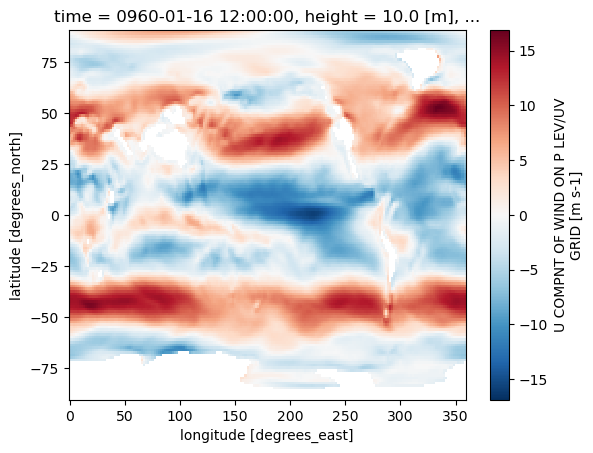

In [116]:
U.sel(pressure = 85000).plot()

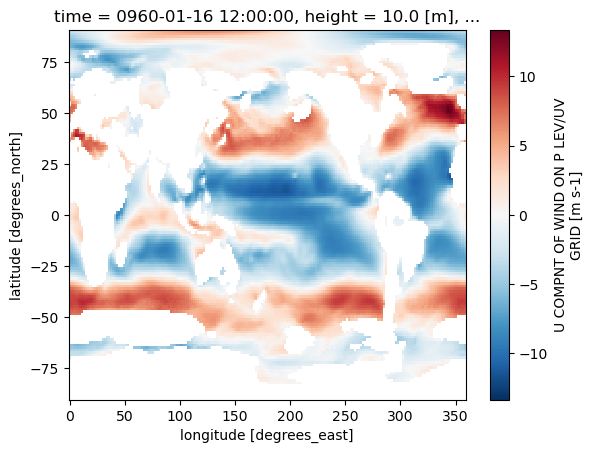

In [122]:
U.sel(pressure = 100000).plot()

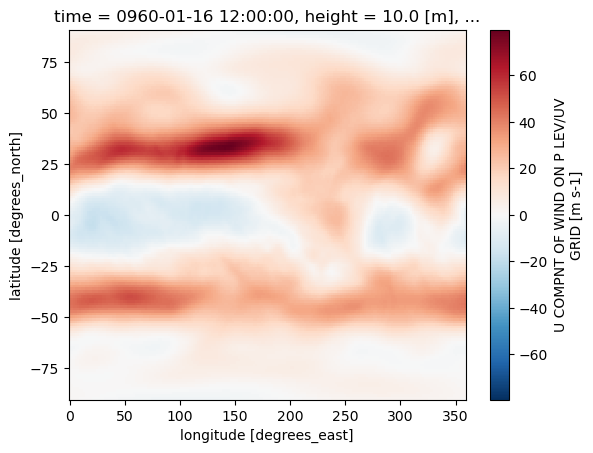

In [118]:
U.sel(pressure = 20000).plot()

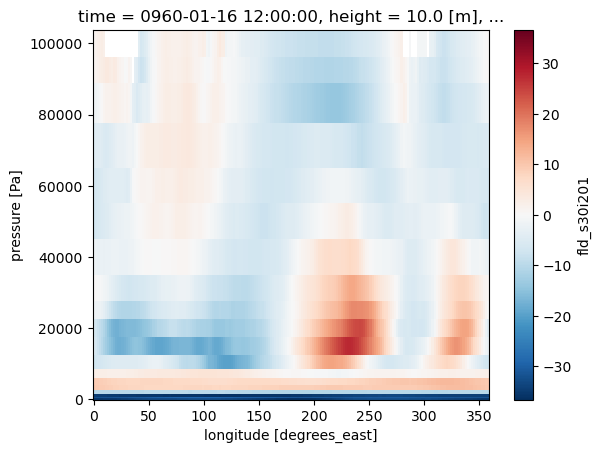

In [121]:
U.sel(lat_v =slice(-5,5)).mean("lat_v").plot()

In [123]:
#laod in Pascal data and create plots of above

In [6]:
data_dir = "/g/data/e14/sm2435/Pascal_runs/Pacemakers/"

In [7]:
#load in LSM
LSM = xr.open_dataset(data_dir+"echam_mesh_mask_oce.nc").nmask.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')[::-1]


In [8]:
def regrid_sintex(ds, var):
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #create regridder
    regridder_1deg = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds[var].chunk({'longitude': -1, 'latitude': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [40]:
def load_sintex_atmos(file):
    data_dir = "/g/data/e14/sm2435/Pascal_runs/Pacemakers/"
    var = file.split('_')[-1].split('.')[0]
    ds = xr.open_dataset(data_dir+file, use_cftime=True, chunks = {"time":240}).rename(
        {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
    #ds = ds.where(LSM==1)
    ds = regrid_sintex(ds, var)
    ds = ds.compute()
    ds = roll_lon(ds)
    return ds

In [9]:
def load_sintex(file):
    data_dir = "/g/data/e14/sm2435/Pascal_runs/Pacemakers/"
    var = file.split('_')[-1].split('.')[0]
    ds = xr.open_dataset(data_dir+file, use_cftime=True, chunks = {"time":240}).rename(
        {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
    ds = ds.where(LSM==1)
    ds = regrid_sintex(ds, var)
    ds = ds.compute()
    ds = roll_lon(ds)
    return ds

In [10]:
sinctrl = load_sintex("REFADA_1m_000101_021012_tsurf.nc")

In [11]:
sinoc = load_sintex("FTP_1m_000101_005012_tsurf.nc")

In [12]:
sinmc = load_sintex("FTPC_1m_000101_011012_tsurf.nc")

In [13]:
sinctrl_z20 = load_sintex("REFADA_1m_000101_021012_20d.nc")

In [14]:
sinoc_z20 = load_sintex("FTP_1m_000101_005012_20d.nc")

In [15]:
sinmc_z20 = load_sintex("FTPC_1m_000101_011012_20d.nc")

In [41]:
sinctrl_psl = load_sintex_atmos("REFADA_1m_000101_021012_slp.nc")

In [42]:
sinoc_psl = load_sintex_atmos("FTP_1m_000101_005012_slp.nc")

In [43]:
sinmc_psl = load_sintex_atmos("FTPC_1m_000101_011012_slp.nc")

In [44]:
sinctrl_u = load_sintex_atmos("REFADA_1m_000101_021012_u10.nc")

In [45]:
sinoc_u = load_sintex_atmos("FTP_1m_000101_005012_u10.nc")

In [46]:
sinmc_u = load_sintex_atmos("FTPC_1m_000101_011012_u10.nc")

In [47]:
sinctrl_v = load_sintex_atmos("REFADA_1m_000101_021012_v10.nc")

In [48]:
sinoc_v = load_sintex_atmos("FTP_1m_000101_005012_v10.nc")

In [49]:
sinmc_v = load_sintex_atmos("FTPC_1m_000101_011012_v10.nc")

In [50]:
sinctrl_pr = load_sintex_atmos("REFADA_1m_000101_021012_precip.nc")

In [51]:
sinoc_pr = load_sintex_atmos("FTP_1m_000101_005012_precip.nc")

In [52]:
sinmc_pr = load_sintex_atmos("FTPC_1m_000101_011012_precip.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'No ENSO - CTRL SST')

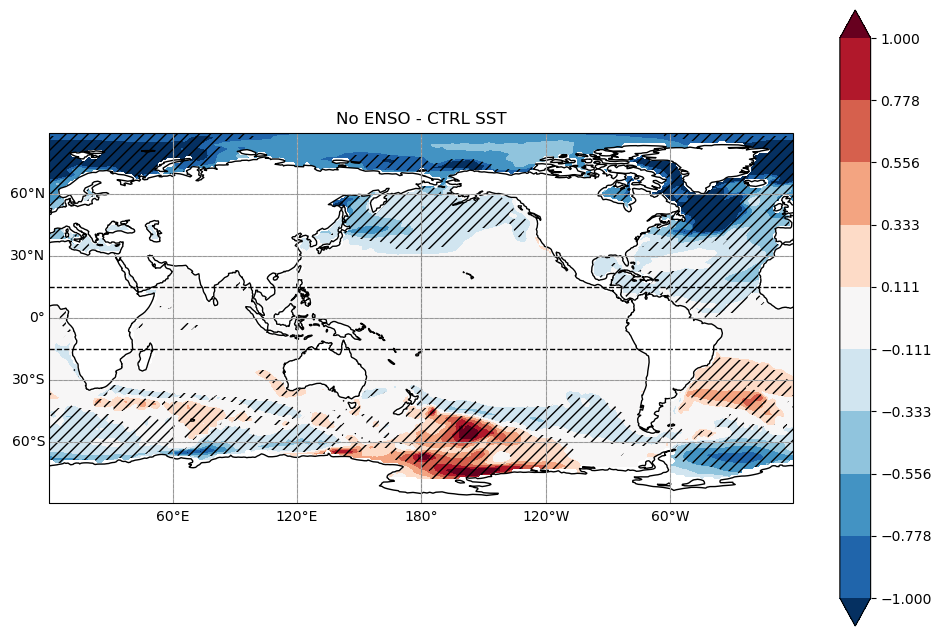

In [78]:
plot_bias_sig_annual(sinctrl, sinmc, temp_scale=1)
plt.title("No ENSO - CTRL SST")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'No ENSO no Bias - CTRL SST')

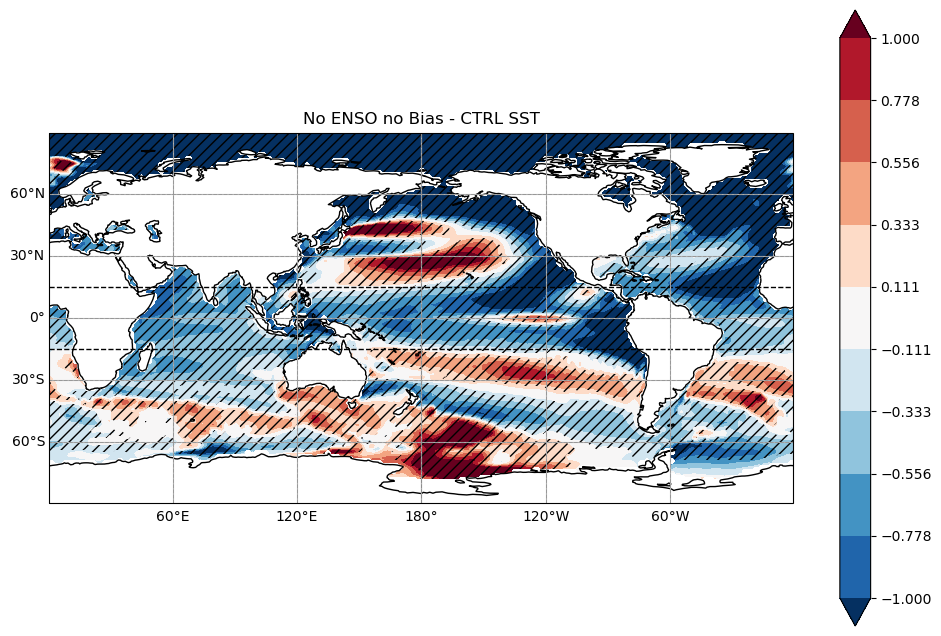

In [64]:
plot_bias_sig_annual(sinctrl, sinoc, temp_scale=1)
plt.title("No ENSO no Bias - CTRL SST")

In [53]:
plot_bias_sig_annual_pr(sinctrl_pr, sinoc_pr, temp_scale=100)
plt.title("No ENSO no Bias - CTRL Precip")

NameError: name 'plot_bias_sig_annual_pr' is not defined

In [ ]:
plot_bias_sig_annual_pr(sinctrl_pr, sinmc_pr, temp_scale=100)
plt.title("No ENSO - CTRL Precip")

In [ ]:
plot_bias_sig_annual(sinctrl_psl, sinoc_psl, temp_scale=100)
plt.title("No ENSO no Bias - CTRL PSL")

In [ ]:
plot_bias_sig_annual(sinctrl_psl, sinmc_psl, temp_scale=100)
plt.title("No ENSO - CTRL PSL")

In [89]:
sinmc_z20.rename({"time_counter":"time"})

<xarray.DataArray (time: 1320, latitude: 180, longitude: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * time       (time) object 0001-01-16 12:00:00 ... 0110-12-15 12:00:00
  * longitude  (longitude) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

/jobfs/97246631.gadi-pbs/ipykernel_1508556/2324497798.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = ttest_ind(exp, ctrl)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'No ENSO no Bias - CTRL z20')

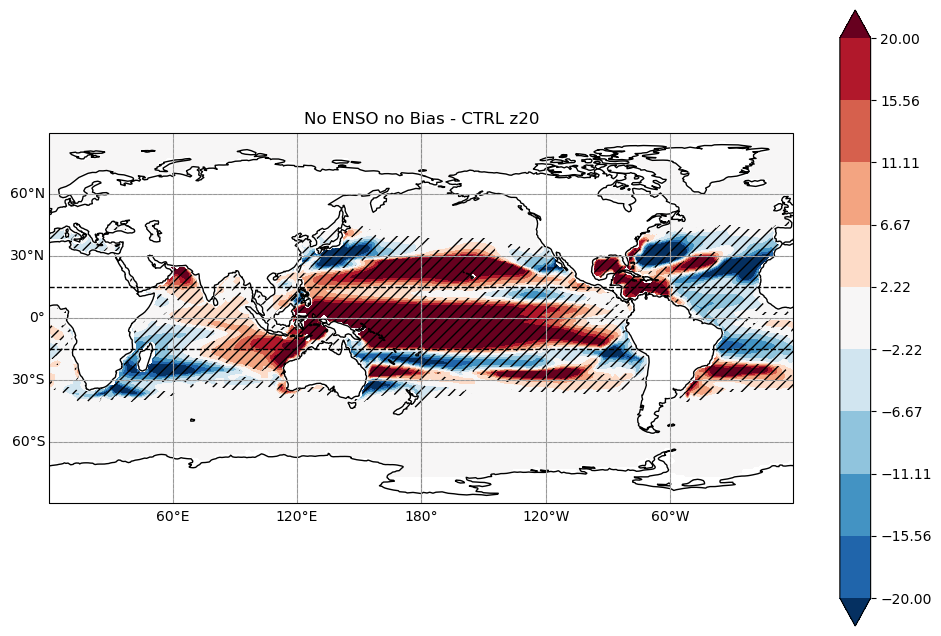

In [90]:
plot_bias_sig_annual(sinctrl_z20.rename({"time_counter":"time"}), sinoc_z20.rename({"time_counter":"time"}), temp_scale=20)
plt.title("No ENSO no Bias - CTRL z20")

In [ ]:
plot_bias_sig_annual(sinctrl_z20.rename({"time_counter":"time"}), sinmc_z20.rename({"time_counter":"time"}), temp_scale=20)
plt.title("No ENSO - CTRL z20")

/jobfs/97246631.gadi-pbs/ipykernel_1508556/2324497798.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = ttest_ind(exp, ctrl)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'No ENSO - CTRL z20')

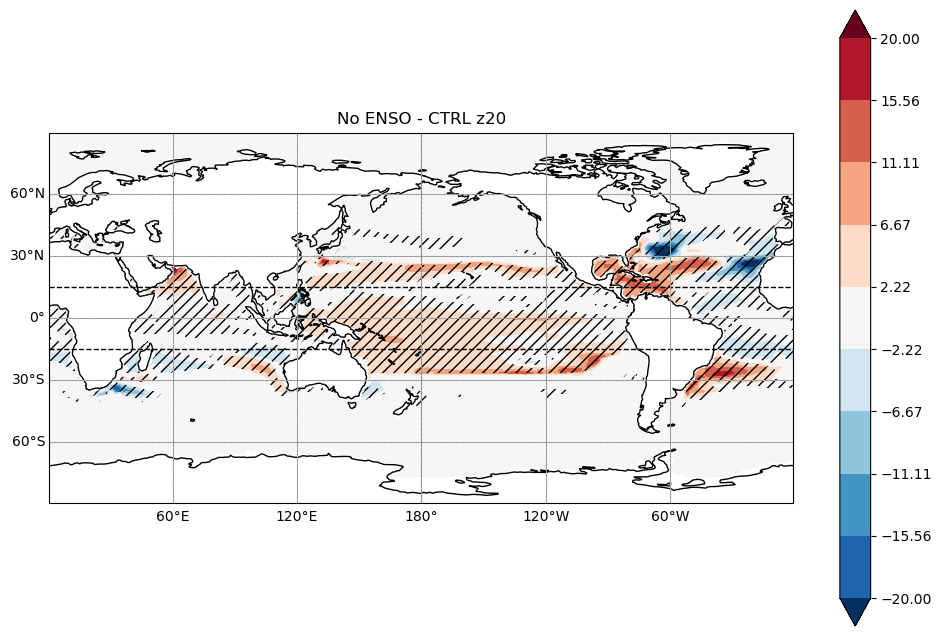

In [92]:
plot_bias_sig_annual(sinctrl_z20.rename({"time_counter":"time"}), sinmc_z20.rename({"time_counter":"time"}), temp_scale=20)
plt.title("No ENSO - CTRL z20")

In [102]:
#now write a fucntion to output bias and to optioanlly plot
def plot_bias_sig(exp_u, exp_v, ref_u, ref_v, temp_scale = 2):
    # Ref dataset
    ref_str = np.sqrt(ref_u**2+ref_v**2)
    ref_u = ref_u.mean('time')
    ref_v = ref_v.mean('time')
    ref_spd = ref_str.mean('time')
    # Exp dataset
    exp_str = np.sqrt(exp_u**2+exp_v**2)
    exp_u = exp_u.mean('time')
    exp_v = exp_v.mean('time')
    exp_spd = exp_str.mean('time')  
    #Now get bias
    u_bias = exp_u - ref_u
    v_bias = exp_v - ref_v
    spd_bias = exp_spd - ref_spd
    # Now plot figure
    plt.figure(figsize = (12,8))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    spd_bias.plot.contourf(ax=ax, vmin = -1*temp_scale, vmax = temp_scale, cmap = "RdBu_r", levels = 10, extend = 'both',
           transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='wind stress bias'))

    Q = ax.quiver(u_bias.longitude[::10].values, u_bias.latitude[::5].values,
                  u_bias[::5,::10].values, v_bias[::5,::10].values, 
              transform=ccrs.PlateCarree(), scale = 15, scale_units = 'width', width = 0.0015, headlength=3)

    #ax.set_title('Annual mean SST bias')
    ax.coastlines(color = 'k')
    ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
    ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
    ax.gridlines()
    #ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    qk = ax.quiverkey(Q, 0.9, 1.1, 1, r'$1 \frac{m}{s}$', labelpos='E',
               coordinates='axes')
    return 


In [ ]:
plot_bias_sig(sinoc_u, sinoc_v, sinctrl_u, sinctrl_v)

In [ ]:
plot_bias_sig(sinmc_u, sinmc_v, sinctrl_u, sinctrl_v)

In [ ]:
#lets do some IOD and Ningaloo Nino analysis

In [30]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def NINO34_sst(DS):
     return (DS).sel(latitude=slice(-5, 5),longitude=slice(360-170, 360-120)).mean(['latitude', 'longitude'])
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(360-170, 360-120)).mean(['latitude', 'longitude'])
def iobm(DS):
     return ssta(DS).sel(latitude=slice(-20, 20),longitude=slice(40, 110)).mean(['latitude', 'longitude'])
    
def dmi(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return  WTIO-SETIO
def siod(DS):
    west = ssta(DS).sel(latitude=slice(-37, -27),longitude=slice(55, 65)).mean(['latitude', 'longitude'])
    east = ssta(DS).sel(latitude=slice(-28, -18),longitude=slice(90, 100)).mean(['latitude', 'longitude'])
    return  west-east
def Ningaloo2(DS):
    return ssta(DS).sel(latitude=slice(-28, -22),longitude=slice(112, 114)).mean(['latitude', 'longitude'])

In [36]:
def plot_index_ranges_SINTEX(index):
    #step 0 get the index
    da = index(sinctrl)
    index_std_dev = da.groupby('time.month').std('time')
    # Step 1: Number of iterations
    num_iterations = 1000
    # Step 2 and 3: Loop over the iterations
    std_deviations = []
    for _ in range(num_iterations):
        # Step 2: Randomly select 30 years with replacement
        random_years = np.random.choice(da['time.year'], size=60, replace=True)

        # Step 3: Calculate the standard deviation for the selected 30 years
        selected_years_data = da.sel(time=np.isin(da['time.year'], random_years))
        std_dev = selected_years_data.groupby('time.month').std(dim='time')

        # Step 4: Store the standard deviation value
        std_deviations.append(std_dev)

    # Step 5: Calculate the 5th and 95th percentiles
    std_deviations = xr.concat(std_deviations, dim='iterations')
    percentiles = std_deviations.quantile([0.05, 0.95], dim = 'iterations')
    #now we can produe the plot:
    plt.figure(figsize = (10,6))
    plt.errorbar(index_std_dev.month, index_std_dev, yerr=[index_std_dev-percentiles[0], percentiles[1]-index_std_dev]
                 , fmt='-o', capsize=5, label = 'CTRL')
    index(sinmc).groupby('time.month').std('time').plot(label = "no_ENSO")
    index(sinoc).groupby('time.month').std('time').plot(label = "no_ENSO_no_bias")
    #index(VC.sel(time=slice("0953-01-01", "1020-12-31"))).groupby('time.month').std('time').plot(label = "ENSO_no_bias")
    plt.xlabel('month')
    plt.ylabel('standard deviation')
    plt.grid(True)
    plt.legend()
    return

In [32]:
def plot_index_ranges(index):
    #step 0 get the index
    da = index(ctrl)
    index_std_dev = da.groupby('time.month').std('time')
    # Step 1: Number of iterations
    num_iterations = 1000
    # Step 2 and 3: Loop over the iterations
    std_deviations = []
    for _ in range(num_iterations):
        # Step 2: Randomly select 30 years with replacement
        random_years = np.random.choice(da['time.year'], size=68, replace=True)

        # Step 3: Calculate the standard deviation for the selected 30 years
        selected_years_data = da.sel(time=np.isin(da['time.year'], random_years))
        std_dev = selected_years_data.groupby('time.month').std(dim='time')

        # Step 4: Store the standard deviation value
        std_deviations.append(std_dev)

    # Step 5: Calculate the 5th and 95th percentiles
    std_deviations = xr.concat(std_deviations, dim='iterations')
    percentiles = std_deviations.quantile([0.05, 0.95], dim = 'iterations')
    #now we can produe the plot:
    plt.figure(figsize = (10,6))
    plt.errorbar(index_std_dev.month, index_std_dev, yerr=[index_std_dev-percentiles[0], percentiles[1]-index_std_dev]
                 , fmt='-o', capsize=5, label = 'CTRL')
    index(MC.sel(time=slice("0953-01-01", "1020-12-31"))).groupby('time.month').std('time').plot(label = "no_ENSO")
    index(OC.sel(time=slice("0953-01-01", "1020-12-31"))).groupby('time.month').std('time').plot(label = "no_ENSO_no_bias")
    index(VC.sel(time=slice("0953-01-01", "1020-12-31"))).groupby('time.month').std('time').plot(label = "ENSO_no_bias")
    plt.xlabel('month')
    plt.ylabel('standard deviation')
    plt.grid(True)
    plt.legend()
    return

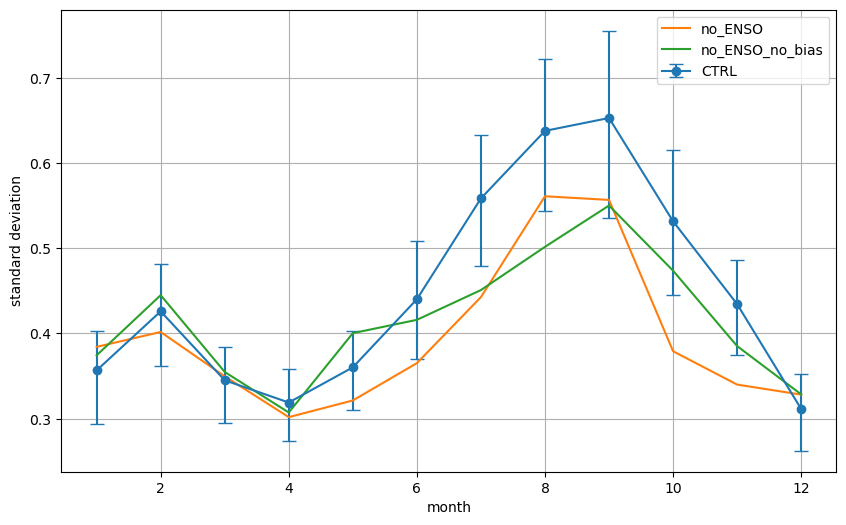

In [37]:
plot_index_ranges_SINTEX(dmi)

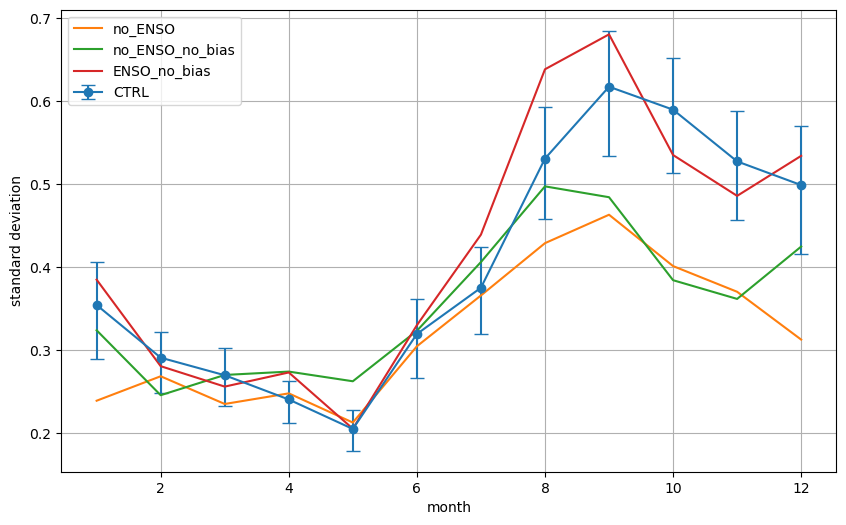

In [57]:
plot_index_ranges(dmi)

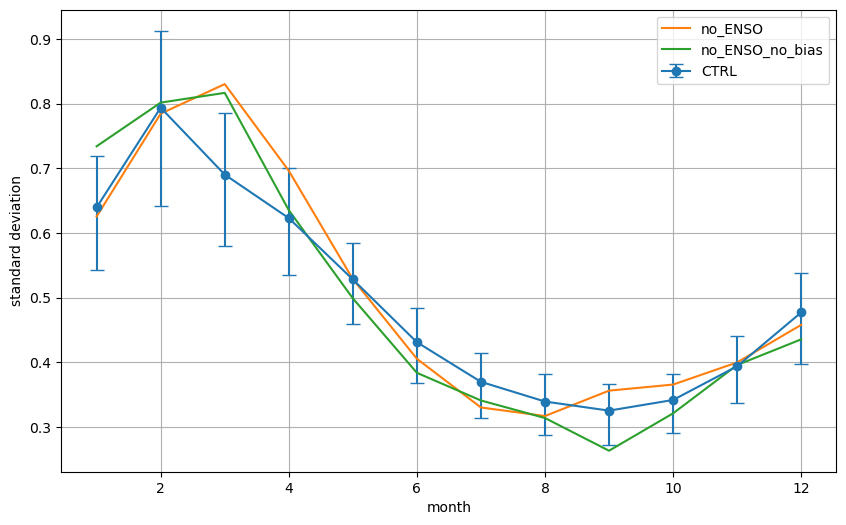

In [38]:
plot_index_ranges_SINTEX(Ningaloo2)

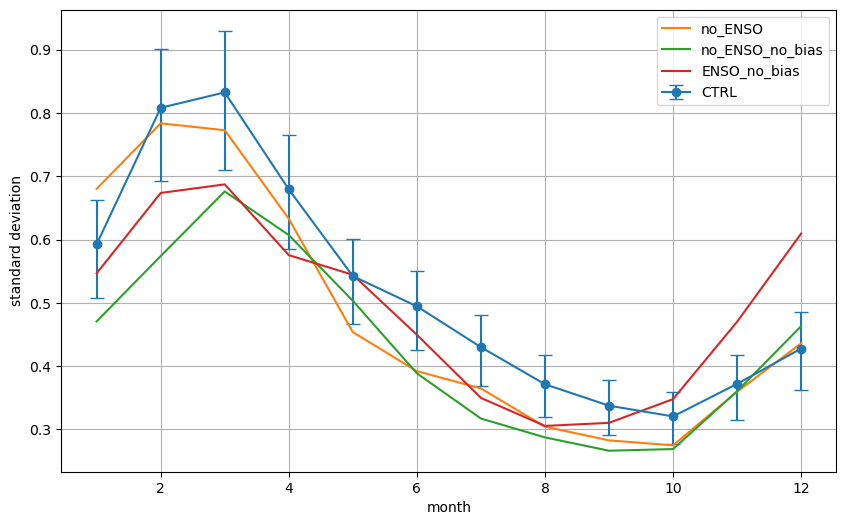

In [58]:
plot_index_ranges(Ningaloo2)

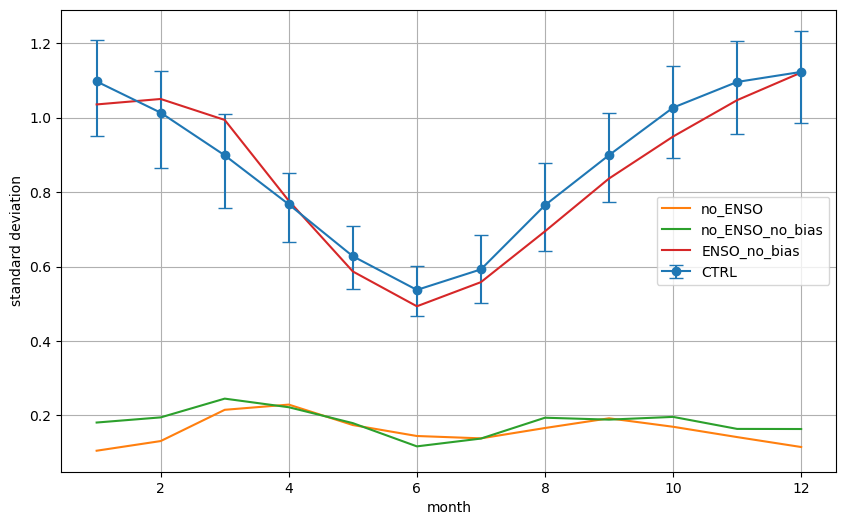

In [64]:
plot_index_ranges(NINO34)

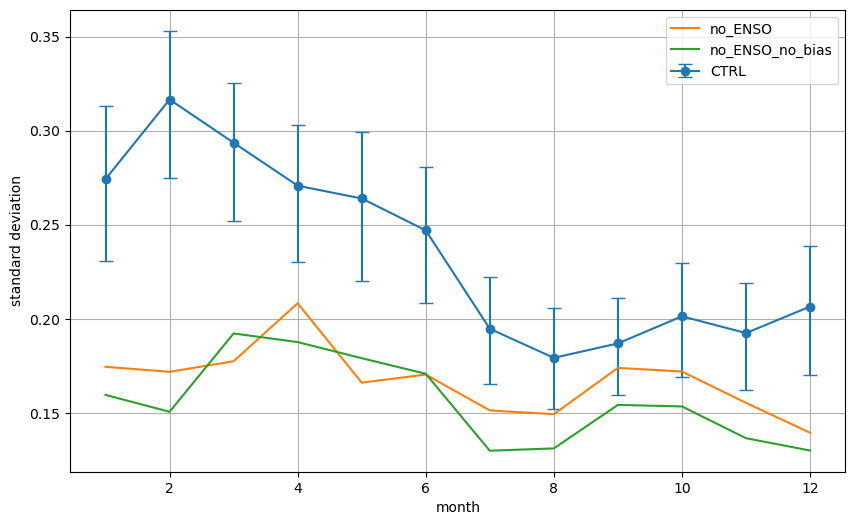

In [39]:
plot_index_ranges_SINTEX(iobm)

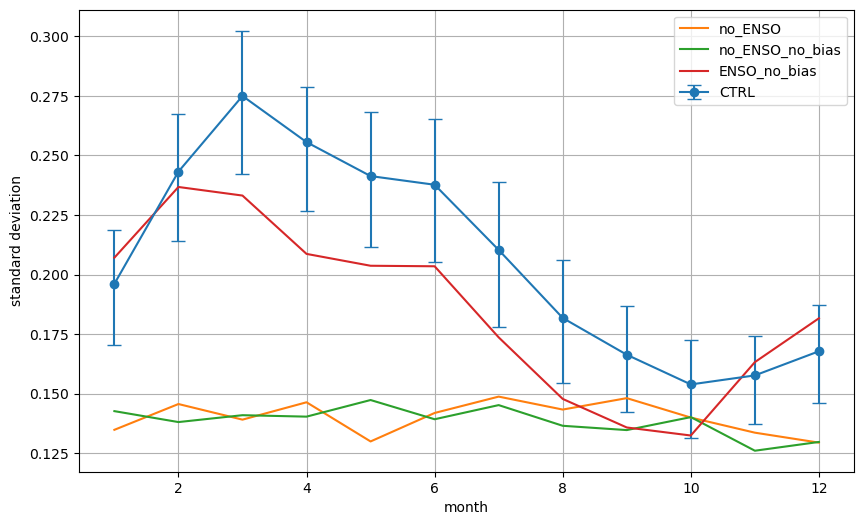

In [65]:
plot_index_ranges(iobm)